In [28]:
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import numpy
import matplotlib.pyplot as plt
import re
import numpy as np

import matplotlib.patches as mpatches
import requests
import sys
from pathlib import Path

In [29]:
sns.set_style("darkgrid", 
      {'axes.facecolor': '#eeeeee',
     'axes.labelcolor': '0',
     'text.color': '0',
     'xtick.color': '0',
     'ytick.color': '0',
     'xtick.bottom': True,
      })
sns.set_context("notebook")

# Compare quicksand and MEGAN pipeline

To test the performance of quicksand compared to the Blast+MEGAN based approach described in Slon et al. (2017), we reanalyzed a selection of sediment samples published in Zavala et al. (2021) obtained from Denisova Cave using quicksand

# Denisova Cave MC SE Profile

We only look at the MAIN Chamber, South-East Profile

1. For each sample, get the correct coordinates within the Main chamber profile

In [30]:
#The sheet is a table representing the coordinates in x and y **cells**
# like this:
#    x1  x2  x3  x4
# Y1 NA  NA  NA M2
# Y2 NA  M24 NA M3
# Y3 NA  M23 NA M4
# Y4 NA  M22 M1 M5

coord = pd.read_csv("assets/MAIN_SE points_markers.csv", sep=";")
coord['y']=coord.index
coord.columns = [x.replace('0.','') for x in coord.columns]

In [31]:
# What I want is simpy
# Marker -> X -> Y
# So I need to melt/depivot the dataframe

coord = coord.melt(id_vars=['y'], value_vars=coord.columns)
coord = coord[(coord.value != None)&(coord.value != 0)]
coord = coord[coord.value.str.startswith("M")]
coord.columns = ['y','x','marker']

In [32]:
#convert dtypes
coord['x'] = coord.x.astype(int)
coord['y'] = coord.y.astype(int)

In [33]:
#find the relative points of coordx and coordy
#this is required to plot them later on top of the image
coord['relx'] = coord.x.apply(lambda x: x/max(coord['x']))
coord['rely'] = coord.y.apply(lambda x: x/max(coord['y']))

In [34]:
#now I need to add the our sample IDs to the dataframe
samples = pd.read_csv('assets/rinput_humanMT_base.txt', sep='\t')
samples = samples[samples.marker == samples.marker] #remove NaN
samples = samples[['SampleID','marker']].drop_duplicates(subset=['SampleID','marker'])
samples = {k.strip():v.strip() for k,v in zip(samples['marker'], samples['SampleID'])}
coord['SampleID'] = coord['marker'].map(samples)

## AA163
### AA163: Human lineage support

This is the analysis of the human capture data from the sample samples. First we need to define the parameters

In [35]:
MIN_SUPPORT = 10 #minimum % support per lineage
MODE = "support" #deam if only deam, support if all sequences 
TERM = 3

The file for the human lineage support was created using Matthias `sediment_summary_quicksand.pl` script:

```
/home/mmeyer/perlscripts/solexa/analysis/sediment_summary_quicksand.pl -db ../sediment_database.xlsx -human -query "Denisova" -coverage 0 -deam 3 > /mnt/scratch/merlin/projects/2023_quicksand_paper/04_work/20240215_rerun_Denisova/assets/20240227_mmeyer_seddb_denisova_all_nochimp0.99_deam3.tsv
```

This created summary statistics for all entries in the database that come from Denisova Cave, the Main Chamber samples are then picked in this notebook. 

Note, that this is the command for the terminal *3* positions, for only looking at the terminal *1* position, the `-deam` flag was ommitted. Also, as in the Zavala Paper, we used the sites without Chimp and 99% support for one lineage


In [36]:
# import the human assignments
# we need the last 3 positions as that was done in the Zavala paper
# and we need nochimp0.99

file = "20240227_mmeyer_seddb_denisova_all_nochimp0.99_deam3.tsv"
pl = pd.read_csv(
    f"assets/{file}", 
    sep='\t'
) 
pl = pl.applymap(lambda x: x.strip() if isinstance(x, str) else x)

pl = pl.drop_duplicates(subset=['RunID','CapLibID'])
# we only habe the AA163 now, so filter
pl = pl[pl.ProbeSet == 'AA163'].copy()

In [37]:
zavala21 = pd.read_csv("assets/zavala_all_libs.csv", skiprows=3)
zavala21.columns = [
    'Marker',
    'SampleID',
    'LysateID',
    'IndexLibID',
    'RawSeqs',
    'ReadsFiltered',
    'ReadsMapped',
    'ReadsDeduped',
    '%Hominin',
    'ReadsHominin',
    'DuplicationRate',
    '5CT',
    '3CT',
    '5CTCI',
    '3CTCI',
    'Ancient',
    'Deaminated(term3)',
    'H_support', 
    'H_support_deam', 
    'N-HST_support', 
    'N-HST_support_deam',
    'N_support', 
    'N_support_deam', 
    'HST_support', 
    'HST_support_deam',
    'D_support', 
    'D_support_deam',
    'S_support', 
    'S_support_deam',
    'D-S_support',
    'D-S_support_deam'  
]


In [38]:
zavala21 = zavala21.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# remove the negative controls...
zavala21 = zavala21[zavala21.Marker == zavala21.Marker].copy()
# only keep the main-chamber
zavala21 = zavala21[zavala21.Marker.str.startswith('M')]

In [39]:
# now filter for the libraries that are part of the zavala21 analysis
pl = pl[pl.IndexLibID.isin(zavala21.IndexLibID)]

In [40]:
#based on the raw sequences I can find the corresponding entries in the table
tmp = zavala21[['IndexLibID', 'RawSeqs']].copy()
pl = pl.merge(tmp, on=['IndexLibID','RawSeqs']).copy()

In [41]:
# reduce the datasheets and de-pivot

def convert_dataframe(df, style='quicksand'):

    cols = ['IndexLibID','SampleID','Ancient','H_support_deam',f'Deaminated(term{TERM})']

    aa163 = df[[x for x in df.columns if x in cols or x.endswith(MODE) ]]
    aa163 = aa163.melt(id_vars=cols, value_vars=[x for x in aa163.columns if x.endswith(MODE)])

    # filter for ancient and significant
    if style=='quicksand':
        aa163 = aa163[aa163.Ancient == '++'].copy()
        aa163 = aa163[aa163.value.str.startswith('^^^')].copy()
    else:
        aa163 = aa163[aa163.Ancient == 'Yes'].copy()
        aa163 = aa163[aa163.value.str.startswith('**')].copy()


    #merge with the coordinates
    aa163 = aa163.merge(coord, on=["SampleID"], validate="m:1", how='left')

    #rename the technical terms
    aa163['variable'] = aa163['variable'].map(
        {
         "S_support_deam":"Sima",
         'D-S_support_deam':'Denisova',
         'D_support_deam':'Denisova',
         'H_support_deam':'Human',
         'N-HST_support_deam':'Neanderthal',
         'N_support_deam':'Neanderthal',
         "S_support":"Sima",
         'D-S_support':'Denisova',
         'D_support':'Denisova',
         'H_support':'Human',
         'N-HST_support':'Neanderthal',
         'N_support':'Neanderthal'
        }
    )
    
    # keep ancient human only if _deam is significant too
    aa163 = aa163[
    (aa163[['variable', 'H_support_deam']].apply(
        lambda x: x[0]=='Human' and (x[1].startswith("^^^") or x[1].startswith("**")),axis=1)) |
    (aa163['variable']!='Human')
    ]
    
    
    return aa163

Note from Zavala et al., 2021: "The presence of ancient modern human mtDNA was evaluated by restricting the analysis to deaminated fragments to mitigate the effect of present-day human DNA contamination"

In [42]:
def print_map(df):

    #this is for the legend
    colors_dict = {
        #"Sima":"green",
        "Denisova":"red",
        "Neanderthal":"blue",
        "Human":"yellow",
    }

    handles = []
    for label,color in colors_dict.items():
        patch = mpatches.Patch(color=color, label=label)
        handles.append(patch)

    # and now the figure
    fig = plt.figure(figsize=(9, 16))
    #main frame
    back = fig.add_axes([0,0,1,1])

    #print the background
    img = plt.imread("assets/Figure_backgrounds/MAIN_SE_without column_blue and orange background.png")
    back.imshow(img)
    plt.legend(
        handles=handles, 
        prop={'size':17}, 
        facecolor='white', 
        edgecolor='black',
        bbox_to_anchor=(0,0,0.95,0.9))

    #add the points
    for n,(i,grp) in enumerate(coord.groupby('marker')):
        x = set(grp['relx']).pop() *0.85 +0.05 #this is to fit it to the padding of the image
        y = 1-set(grp['rely']).pop() *0.88 - 0.07 #
        spid = set(grp['SampleID']).pop()

        data=df[df.marker==i].copy()

        if x==x and y==y:        
            wedgeprops = {"edgecolor":"k", "linewidth":1}

            ax = fig.add_axes([x,y,0.025,0.02])
            ax.pie([1],colors=["white"], wedgeprops=wedgeprops) #plot an empty white pie for negative

            #now check if 
            data['support'] = data['value'].apply(lambda x: int(re.search("[0-9]+",x).group()))
            data['sizes'] = data['value'].apply(lambda x: int(re.search("(?<=\()[0-9]+",x).group()))

            data=data[data.support > MIN_SUPPORT].copy()        
            data = data.groupby("variable",as_index=False).mean()

            if 'sizes' in data.columns:
                colors = [colors_dict[x] if x in colors_dict else "grey" for x in data["variable"]]
                ax.pie(data['sizes'], colors=colors, wedgeprops=wedgeprops)
                   

In [43]:
qs = convert_dataframe(pl)
zav = convert_dataframe(zavala21, style='megan')

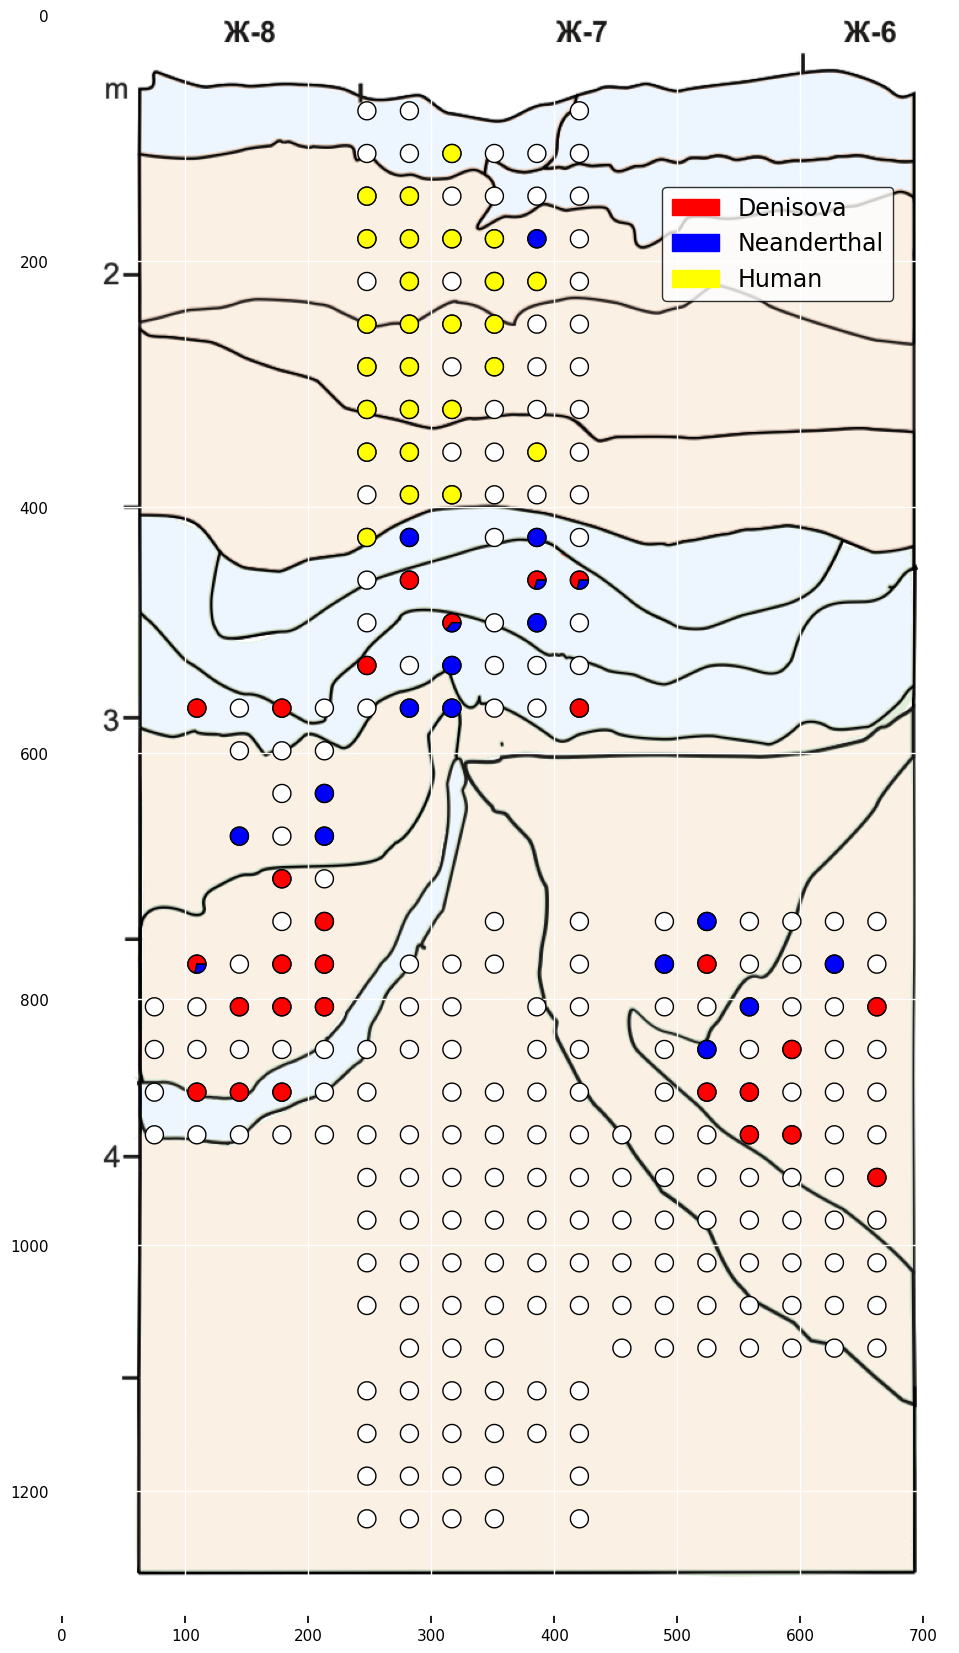

In [44]:
print_map(zav)

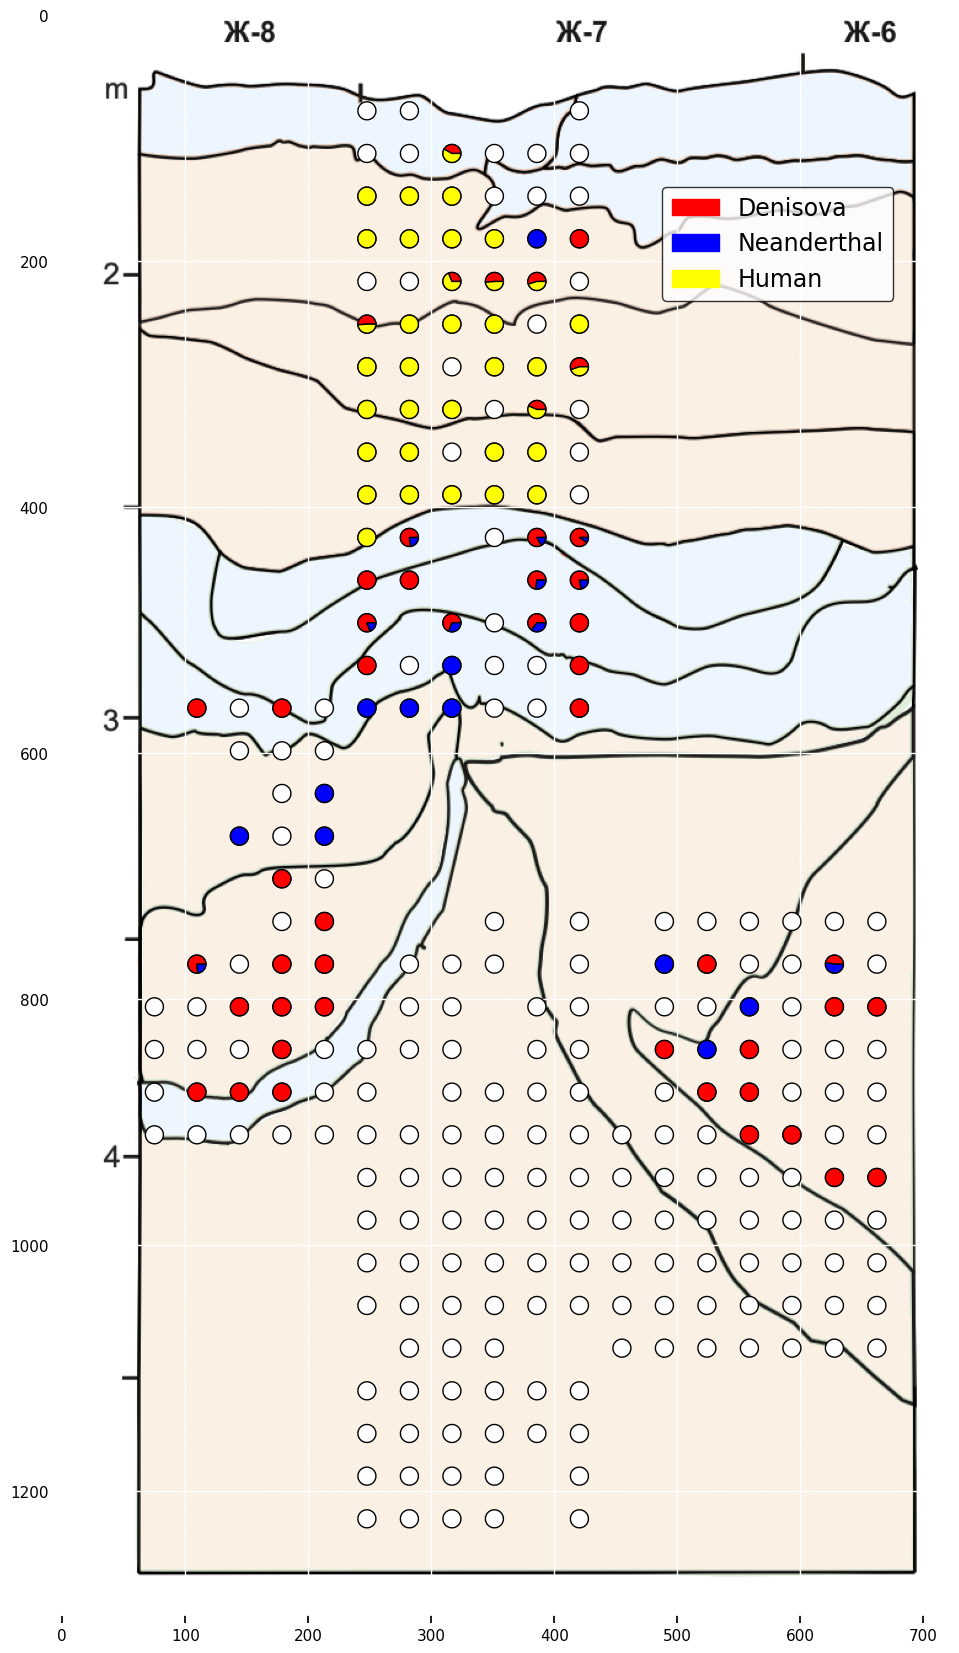

In [45]:
print_map(qs)

### AA163: Number of reads

In [46]:
# and the differences in general
